In [6]:
import os
import cv2
import glob
import h5py
import shutil

import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

Using TensorFlow backend.


In [7]:
## I said it earlier as well, do everything you can to make your results reproducible. It matters!!

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [10]:
# Define path to the data directory
# give the path to your dataset
data_dir = Path('Datasets/Set1/')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [12]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'COVID-19-PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.*g')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')

train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_df.head()

,image,label
0,Datasets\Set1\train\NORMAL\normal_Chaand7ea7de...,0
1,Datasets\Set1\train\NORMAL\normal_Chaand7e5673...,0
2,Datasets\Set1\train\COVID-19-PNEUMONIA\BACTERI...,1
3,Datasets\Set1\train\COVID-19-PNEUMONIA\pneumon...,1
4,Datasets\Set1\train\NORMAL\normal_Chaand78daac...,0


1    9619
0    9315
Name: label, dtype: int64


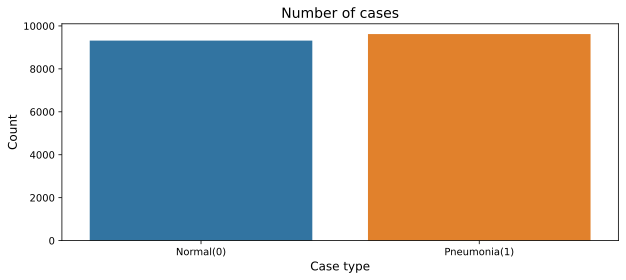

In [13]:
# Get the counts for each class
cases_count = train_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

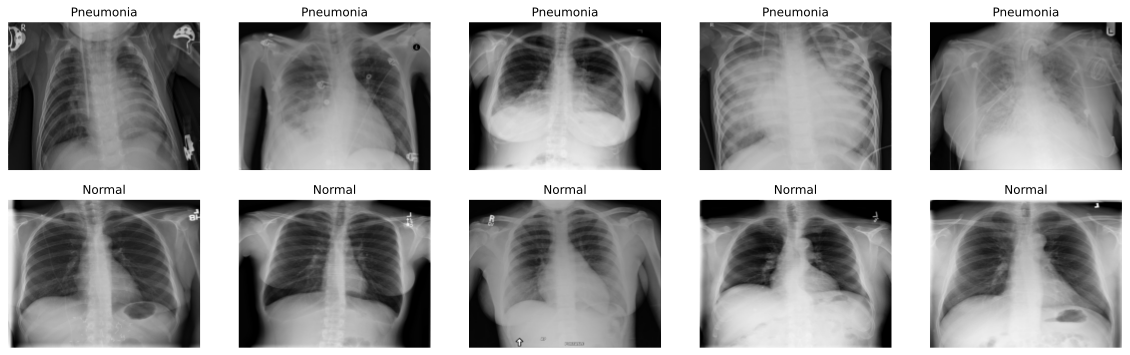

In [14]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(20,6))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [15]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # roatation

In [16]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3
# batch size for training  
batch_size=16

In [17]:
def data_generator(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size,), dtype=np.float32)
    
    while True:
        # shuffle indices for the training data
        np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = seq.augment_image(img)
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                label = data.iloc[idx]["label"]
                
                batch_data[j] = img
                batch_labels[j] = label
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [18]:
# training data generator 
train_data_gen = data_generator(train_df, batch_size)

In [19]:
def read_images(images, label):
    """
    This function read images from a list of the given
    images. For each image it records a corresponding label.
    
    Args:
        images: list of all images
        label(int): label for these images
    
    Returns:
        data: numpy array containing pre-processed images. The pre-processing
              function is provided by keras
        labels: numpy array of corresponding labels
    """
    data = []
    for img in images:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
        data.append(img)
    
    labels = [label]*len(data)
    data = np.array(data).astype(np.float32)
    data = preprocess_input(data)
    return data, labels

########################################################################################

def prepare_data(data_dir):
    """
    This function can be used to prepare the 
    validation and test datasets. 
    
    Args:
        data_dir: A pathlib object pointing to validation/test directory
    
    Returns:
        data: numpy array of all images
        labels: numpy array of corresponding labels
    """
    normal_cases_dir = data_dir / 'Normal'
    pneumonia_cases_dir = data_dir / 'Covid-19-pneumonia'

    # Get the list of all the images
    normal_cases = list(normal_cases_dir.glob('*.*g'))
    pneumonia_cases = list(pneumonia_cases_dir.glob('*.*g'))
    print(f"Found {len(normal_cases)} normal cases and {len(pneumonia_cases)} pneumonia_cases")
    
    # process class-wise
    normal_cases_data, normal_cases_labels = read_images(normal_cases, 0)
    pneumonia_cases_data, pneumonia_cases_labels = read_images(pneumonia_cases, 1)
    
    # sanity-check
    assert len(normal_cases_data) == len(normal_cases_labels), "You had one job!"
    assert len(pneumonia_cases_data) == len(pneumonia_cases_labels), "You can't get it right, can you?"
    
    data = np.vstack((normal_cases_data, pneumonia_cases_data))
    labels = np.array((normal_cases_labels + pneumonia_cases_labels)).astype(np.float32)
    
    return data, labels

In [20]:
# Prepare validation data 
validation_data, validation_labels = prepare_data(train_dir)
print(f"Number of validation images: {len(validation_data)} and labels: {len(validation_labels)}")
print(validation_data.shape, validation_labels.shape)

Found 9315 normal cases and 9619 pneumonia_cases
Number of validation images: 18934 and labels: 18934
(18934, 224, 224, 3) (18934,)


In [22]:
# Prepare test data
test_data, test_labels = prepare_data(test_dir)
print("Number of samples in test data: ", len(test_data))
print(test_data.shape, test_labels.shape)

Found 1119 normal cases and 1014 pneumonia_cases
Number of samples in test data:  2133
(2133, 224, 224, 3) (2133,)


In [23]:
# Get fine-tuning/transfer-learning model
def get_fine_tuning_model(base_model, top_model, inputs, learning_type):
    if learning_type=='transfer_learning':
        print("Doing transfer learning")
        K.set_learning_phase(0)
        base_model.trainable = False
        features = base_model(inputs)
        outputs = top_model(features)
    else:
        print("Doing fine-tuning")
        base_model.trainable = True
        features = base_model(inputs)
        outputs = top_model(features)
    return Model(inputs, outputs)

In [24]:
# Get the base model
base_model = ResNet50(input_shape=(img_rows, img_cols, img_channels), 
                       weights='imagenet', 
                       include_top=False, 
                       pooling='avg')

94658560/94653016 [==============================] - 40s 0us/step


In [25]:
# Define a top model: extra layers that we are going to add on top of our base network
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Dense(50, activation='relu', name='fc1')(feature_inputs)
x = Dropout(0.3,name='drop')(x)
outputs = Dense(1, activation='sigmoid', name='fc2')(x)
top_model = Model(feature_inputs, outputs, name='top_model')

In [26]:
# get model for tranfser learning
inputs = Input(shape=(img_rows, img_cols, img_channels))
model = get_fine_tuning_model(base_model, top_model, inputs, "transfer_learning")
model.summary()

Doing transfer learning
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
top_model (Model)            multiple                  102501    
Total params: 23,690,213
Trainable params: 102,501
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [28]:
# compile the model and check it 
optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss=focal_loss(), optimizer=optimizer, metrics=['accuracy'])

In [29]:
# always use earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=5, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))

# number of epochs 
nb_epochs=10

In [ ]:
# train the model 

history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=(validation_data, validation_labels),
                              callbacks=[es,chkpt],
                              class_weight={0:1.0, 1:0.33},
                              use_multiprocessing=True, workers=8)

Epoch 1/10
1184/1184 [==============================] - 587s 496ms/step - loss: 0.0162 - accuracy: 0.8171 - val_loss: 0.0325 - val_accuracy: 0.8448
Epoch 2/10
  97/1184 [=>............................] - ETA: 5:55 - loss: 0.0140 - accuracy: 0.8331

In [ ]:
def graph(trainingAccuracies, testAccuracies, trainingLosses, testLosses):
    plt.style.use("ggplot") 
    plt.figure()
    plt.plot(testLosses, label="Val Loss")
    plt.plot(trainingLosses, label="Train Loss")
    plt.plot(trainingAccuracies, label="Train Acc")
    plt.plot(testAccuracies, label="Val Acc")
    plt.legend()
    plt.show()

In [ ]:
# plot the model loss and accuracy
#print(history1.history)
trainingLosses = history1.history['loss']
trainingAccuracies = history1.history['accuracy']



testLosses = history1.history['val_loss']
testAccuracies = history1.history['val_accuracy']

graph(trainingAccuracies, testAccuracies, trainingLosses, testLosses)

In [ ]:
# evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=batch_size)
print("Test loss: ", test_loss)
print(f"Test set accuracy: {test_acc*100:.2f}%")

In [ ]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [ ]:
model.save("RestNet50_binary_new_with_all_data.h5")